In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

### Base Model Loading

In [2]:
base_model = MobileNet(weights='imagenet', include_top=False)

In [3]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

In [4]:
crck_det = Model(inputs=base_model.input, outputs=predictions)

In [5]:
for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers:
    assert layer.trainable == False

In [6]:
crck_det.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, None, None, 32)    0     

In [7]:
crck_det.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
datagen = image.ImageDataGenerator(
    rescale = 1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)


In [9]:
data_dir = 'Datasets/crack_dataset/'

train_set = datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

test_set = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 32000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


In [11]:
history = crck_det.fit(
    train_set,
    steps_per_epoch=len(train_set),
    epochs=10,
    validation_data=test_set,
    validation_steps=len(test_set)
)


Epoch 1/10
1000/1000 [==============================] - 923s 923ms/step - loss: 0.0133 - accuracy: 0.9967 - val_loss: 0.0040 - val_accuracy: 0.9989
Epoch 2/10
1000/1000 [==============================] - 692s 692ms/step - loss: 0.0069 - accuracy: 0.9980 - val_loss: 0.0079 - val_accuracy: 0.9977
Epoch 3/10
1000/1000 [==============================] - 708s 708ms/step - loss: 0.0065 - accuracy: 0.9981 - val_loss: 0.0042 - val_accuracy: 0.9984
Epoch 4/10
1000/1000 [==============================] - 711s 711ms/step - loss: 0.0061 - accuracy: 0.9981 - val_loss: 0.0055 - val_accuracy: 0.9980
Epoch 5/10
1000/1000 [==============================] - 693s 692ms/step - loss: 0.0046 - accuracy: 0.9986 - val_loss: 0.0026 - val_accuracy: 0.9991
Epoch 6/10
1000/1000 [==============================] - 690s 690ms/step - loss: 0.0056 - accuracy: 0.9984 - val_loss: 0.0096 - val_accuracy: 0.9977
Epoch 7/10
1000/1000 [==============================] - 691s 691ms/step - loss: 0.0039 - accuracy: 0.9990 - val_

In [21]:
import pickle

with open("finetuneMobile.pickle", "wb") as f:
    pickle.dump(history.history, f)

In [25]:
crck_det.save("models/finetuning/synapse_model.h5")

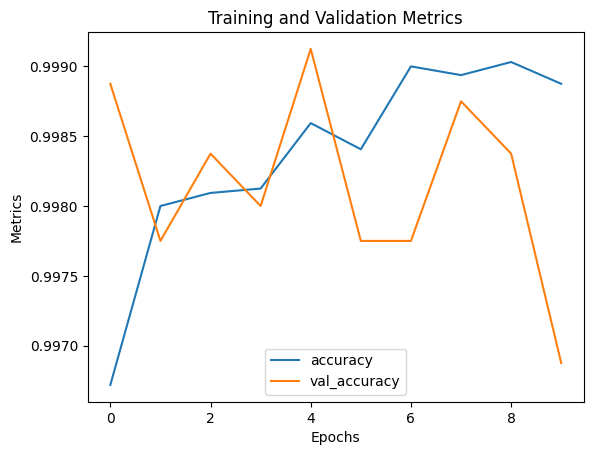

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
selected_metrics = {'accuracy', 'val_accuracy'}
filtered_history = {key: value for key, value in history.history.items() if key in selected_metrics}

# Convert the filtered history to a DataFrame and plot
pd.DataFrame(filtered_history).plot()
plt.ylabel('Metrics')
plt.xlabel('Epochs')
plt.title('Training and Validation Metrics')
plt.show()